# Univariate Time Series Data Forecast for daily minimum temperature in Melbourne

In [27]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass

Begin by looking at the structure of the csv that contains the data:

In [28]:
TEMPERATURES_CSV = './data/daily-min-temperatures.csv'

with open(TEMPERATURES_CSV, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")    
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

"Date","Temp"

First data point looks like this:

"1981-01-01",20.7

Second data point looks like this:

"1981-01-02",17.9



In [29]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

## Parsing the raw data


In [30]:
def parse_data_from_file(filename):
    
    times = list(range(3650))
    temperatures = []

    with open(filename) as csvfile:
        
        ### START CODE HERE
        reader = csv.reader(csvfile, delimiter=',')
        # Skip the first line
        next(reader)

          # Append row and sunspot number to lists
        for row in reader:
            #times.append(range(3500))
            temperatures.append(float(row[1]))
        
        ### END CODE HERE
            
    return times, temperatures


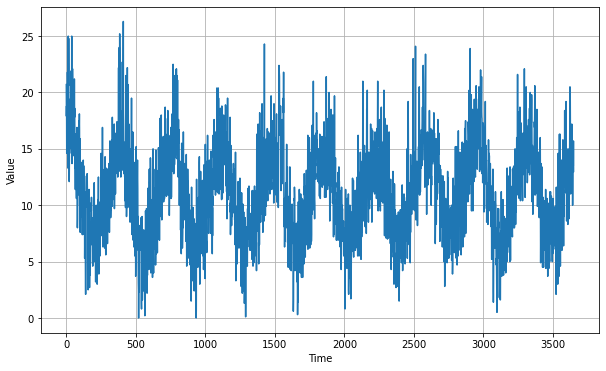

In [31]:
# Test your function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TEMPERATURES_CSV = './data/daily-min-temperatures.csv'
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Processing the data


In [32]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [33]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

## Defining the model architecture


In [36]:
def create_uncompiled_model():

    ### START CODE HERE
    WINDOW_SIZE = 64
    
    model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,strides=1,activation="relu", padding='causal', input_shape=[WINDOW_SIZE, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),    
    ]) 
    
    ### END CODE HERE

    return model

In [37]:
# Test your uncompiled model
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(train_set)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

Your current architecture is compatible with the windowed dataset! :)


## Adjusting the learning rate - (Optional Exercise)


In [40]:
def adjust_learning_rate(dataset):
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
    
    ### START CODE HERE
    
    # Select your optimizer
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    ### END CODE HERE
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [41]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set)

Epoch 1/100
77/77 [==============================] - 11s 109ms/step - loss: 10.2377 - mae: 10.7368 - lr: 1.0000e-04
Epoch 2/100
77/77 [==============================] - 8s 108ms/step - loss: 9.9582 - mae: 10.4569 - lr: 1.1220e-04
Epoch 3/100
77/77 [==============================] - 8s 107ms/step - loss: 9.6036 - mae: 10.1021 - lr: 1.2589e-04
Epoch 4/100
77/77 [==============================] - 8s 109ms/step - loss: 8.8316 - mae: 9.3300 - lr: 1.4125e-04
Epoch 5/100
77/77 [==============================] - 9s 120ms/step - loss: 6.1145 - mae: 6.6057 - lr: 1.5849e-04
Epoch 6/100
77/77 [==============================] - 8s 107ms/step - loss: 2.5913 - mae: 3.0537 - lr: 1.7783e-04
Epoch 7/100
77/77 [==============================] - 8s 106ms/step - loss: 2.3157 - mae: 2.7742 - lr: 1.9953e-04
Epoch 8/100
77/77 [==============================] - 9s 113ms/step - loss: 2.0496 - mae: 2.5051 - lr: 2.2387e-04
Epoch 9/100
77/77 [==============================] - 8s 107ms/step - loss: 1.8656 - mae: 2.

(0.0001, 10.0, 0.0, 10.0)

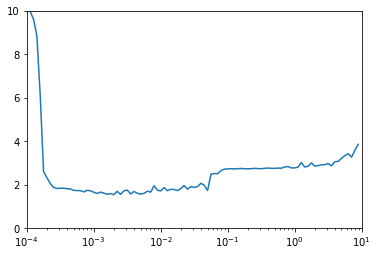

In [42]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 10])

## Compiling the model


In [43]:
def create_model():

    
    model = create_uncompiled_model()

    ### START CODE HERE

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(learning_rate=1.8e-3, momentum=0.9),
                  metrics=["mae"])  
    

    ### END CODE HERE

    return model

In [44]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(train_set, epochs=50)

Epoch 1/50
77/77 [==============================] - 11s 107ms/step - loss: 3.8238 - mae: 4.2935
Epoch 2/50
77/77 [==============================] - 8s 107ms/step - loss: 1.9857 - mae: 2.4406
Epoch 3/50
77/77 [==============================] - 8s 105ms/step - loss: 1.7978 - mae: 2.2501
Epoch 4/50
77/77 [==============================] - 8s 106ms/step - loss: 1.7335 - mae: 2.1834
Epoch 5/50
77/77 [==============================] - 9s 111ms/step - loss: 1.6757 - mae: 2.1221
Epoch 6/50
77/77 [==============================] - 8s 107ms/step - loss: 1.6651 - mae: 2.1121
Epoch 7/50
77/77 [==============================] - 8s 108ms/step - loss: 1.6395 - mae: 2.0864
Epoch 8/50
77/77 [==============================] - 9s 113ms/step - loss: 1.6327 - mae: 2.0786
Epoch 9/50
77/77 [==============================] - 9s 115ms/step - loss: 1.5799 - mae: 2.0226
Epoch 10/50
77/77 [==============================] - 9s 115ms/step - loss: 1.5542 - mae: 1.9965
Epoch 11/50
77/77 [=============================

## Evaluating the forecast


In [45]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

## Faster model forecasts

In [46]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

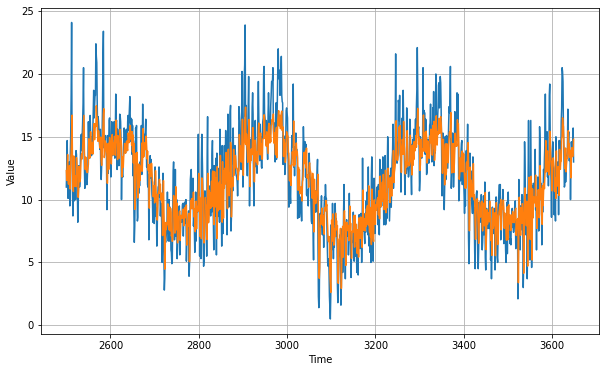

In [47]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [48]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 5.34, mae: 1.81 for forecast


In [49]:
# Save your model in the SavedModel format
model.save('saved_model/my_model')

# Compress the directory using tar
! tar -czvf saved_model.tar.gz saved_model/

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


saved_model/
saved_model/my_model/
saved_model/my_model/keras_metadata.pb
saved_model/my_model/variables/
saved_model/my_model/variables/variables.data-00000-of-00001
saved_model/my_model/variables/variables.index
saved_model/my_model/saved_model.pb
saved_model/my_model/assets/


## End of mini project